In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [3]:
def get_test_real_data(sequence):

    data_real = pd.read_csv("/remote-home/21310019/2024/pv_TSTR/TS/data_folder/ori_pv_start_from_0101.csv",usecols=["PV/kwh"]).values
    data_real_ = data_real[9408:,:].reshape(-1,24)
    def normalization(data):
        _range = np.max(data) - np.min(data)
        return (data - np.min(data)) / _range
    #data_real_ = normalization(data_real)
    #data_real_ = data_real_[9408:,:].reshape(-1,24)

    #class_label = data_npz["arr_1"]
    daily_slice = []
    daily_length_list = []
    daily_length_count = []

    for i in range(data_real_.shape[0]):
        daily = data_real_[i,:]
        sub_slice = []
        for j in range(24):
            if daily[j] != 0:
                daily_length_count.append(j)
                sub_slice.append(daily[j])
        daily_length_list.append(len(sub_slice)) 
        daily_slice.append(sub_slice)  

    #print(len(daily_slice))####416  
    pv_drop0 = None
    for i in range(len(daily_slice)):
        fea = np.array(daily_slice[i])
        if pv_drop0 is None:
            pv_drop0 = fea
        else:
            pv_drop0 = np.concatenate([pv_drop0,fea],axis=0)

    X = []
    Y = []
    for i in range(pv_drop0.shape[0] - sequence):
        X.append(pv_drop0[i:(i + sequence)])##[4,1]
        Y.append(pv_drop0[i + sequence])##1
    print(np.array(X).shape)

    max_value = {}
    min_value = {}

    # 构建batch
    testx_pre = np.array(X)
    testx = normalization(testx_pre)
    
    max_value["testx"] = np.max(testx_pre)
    min_value["testx"] = np.min(testx_pre)

    testy_pre = np.array(Y)
    testy = normalization(testy_pre)
    max_value["testy"] = np.max(testy_pre)
    min_value["testy"] = np.min(testy_pre)

    #return testx_pre,testy_pre
    return testx,testy

def get_fake_data(data_path,sequence):
    
    data_npz = np.load(
            data_path)
    data_real = pd.read_csv("/remote-home/21310019/2024/pv_TSTR/TS/data_folder/ori_pv_start_from_0101.csv",usecols=["PV/kwh"]).values
    
    def normalization(data):
        _range = np.max(data) - np.min(data)
        return (data - np.min(data)) / _range
    
    ori_data = np.mean(data_npz["arr_0"],axis = 1)
    data_real_ = np.concatenate([data_real[:8616,:],data_real[9408:,:]],axis = 0).reshape(-1,24)
    ori_data_ = np.concatenate([normalization(data_real[:8616,:].reshape(-1,24)),normalization(ori_data)],axis = 0)
    #class_label = data_npz["arr_1"]
    daily_slice = []
    daily_length_list = []
    daily_length_count = []

    for i in range(ori_data_.shape[0]):
        daily = ori_data_[i,:]
        sub_slice = []
        for j in range(24):
            if daily[j] != 0:
                daily_length_count.append(j)
                sub_slice.append(daily[j])
        daily_length_list.append(len(sub_slice)) 
        daily_slice.append(sub_slice)  

    #print(len(daily_slice))####416  
    pv_drop0 = None
    for i in range(len(daily_slice)):
        fea = np.array(daily_slice[i])
        if pv_drop0 is None:
            pv_drop0 = fea
        else:
            pv_drop0 = np.concatenate([pv_drop0,fea],axis=0)

    X = []
    Y = []
    for i in range(pv_drop0.shape[0] - sequence):
        X.append(pv_drop0[i:(i + sequence)])##[4,1]
        Y.append(pv_drop0[i + sequence])##1
    print(np.array(X).shape)

    def normalization(data):
        _range = np.max(data) - np.min(data)
        return (data - np.min(data)) / _range

    max_value = {}
    min_value = {}

    # 构建batch
    total_len = len(Y)
    train_len = int(0.9*total_len)

    
    trainx = np.array(X)
    
    max_value["trainx"] = np.max( np.array(X[:int(0.9 * total_len)]))
    min_value["trainx"] = np.min( np.array(X[:int(0.9 * total_len)]))
    
    trainy = np.array(Y)

    max_value["trainy"] = np.max(Y[:int(0.9 * total_len)])
    min_value["trainy"] = np.min(Y[:int(0.9 * total_len)])
     
    testx_pre = np.array(X[int(0.9 * total_len):])
    #testx = normalization(testx_pre)
    
    max_value["testx"] = np.max(testx_pre)
    min_value["testx"] = np.min(testx_pre)

    testy_pre = np.array(Y[int(0.9 * total_len):])
    #testy = normalization(testy_pre)
    max_value["testy"] = np.max(testy_pre)
    min_value["testy"] = np.min(testy_pre)


    return trainx, trainy

In [8]:
def get_train_set(i):
    data_npz = np.load(
            '/remote-home/21310019/2024/pv_TSTR/TS/data_folder/fake_pv_arr_{}.npz'.format(i+1))
    data_real = pd.read_csv("/remote-home/21310019/2024/pv_TSTR/TS/data_folder/ori_pv_start_from_0101.csv",usecols=["PV/kwh"]).values
    
    def normalization(data):
        _range = np.max(data) - np.min(data)
        return (data - np.min(data)) / _range
    
    ori_data = np.mean(data_npz["arr_0"],axis = 1)
    data_real_ = np.concatenate([data_real[:8616,:],data_real[9408:,:]],axis = 0).reshape(-1,24)
    ori_data_ = np.concatenate([normalization(data_real[:8616,:].reshape(-1,24)),normalization(ori_data)],axis = 0)
    #class_label = data_npz["arr_1"]
    daily_slice = []
    daily_length_list = []
    daily_length_count = []

    for i in range(ori_data_.shape[0]):
        daily = ori_data_[i,:]
        sub_slice = []
        for j in range(24):
            if daily[j] != 0:
                daily_length_count.append(j)
                sub_slice.append(daily[j])
        daily_length_list.append(len(sub_slice)) 
        daily_slice.append(sub_slice)  

    #print(len(daily_slice))####416  
    pv_drop0 = None
    for i in range(len(daily_slice)):
        fea = np.array(daily_slice[i])
        if pv_drop0 is None:
            pv_drop0 = fea
        else:
            pv_drop0 = np.concatenate([pv_drop0,fea],axis=0)

    #print("len(test_data):",pv_drop0.shape)
    return normalization(pv_drop0)

def get_train_set_different_ratio(i,bili):
    data_npz = np.load(
            '/remote-home/21310019/2024/pv_TSTR/TS/data_folder/fake_pv_arr_{}.npz'.format(i+1))
    data_real = pd.read_csv("/remote-home/21310019/2024/pv_TSTR/TS/data_folder/ori_pv_start_from_0101.csv",usecols=["PV/kwh"]).values
    
    def normalization(data):
        _range = np.max(data) - np.min(data)
        return (data - np.min(data)) / _range
    
    if bili == 1:
        ori_data = np.mean(data_npz["arr_0"],axis = 1)##[359,8,24]-->[359,24]
        #print("ori_fake_data_shape",ori_data.shape)
        ori_data_ = np.concatenate([normalization(data_real[:8616,:].reshape(-1,24)),normalization(ori_data)],axis = 0)
    elif bili == 2:
        ori_data = np.concatenate([np.mean(data_npz["arr_0"][:,:4,:],axis = 1),
                                   np.mean(data_npz["arr_0"][:,-4:,:],axis = 1)],
                                   axis = 0)##[359,8,24]-->[2*359,24]
        #print("ori_fake_data_shape",ori_data.shape)
        ori_data_ = np.concatenate([normalization(data_real[:8616,:].reshape(-1,24)),normalization(ori_data)],axis = 0)
    else:
        ori_data = data_npz["arr_0"][:,:bili,:].reshape(-1,24)##[359,8,24]-->[2*359,24]
        #print("ori_fake_data_shape",ori_data.shape)
        ori_data_ = np.concatenate([normalization(data_real[:8616,:].reshape(-1,24)),normalization(ori_data)],axis = 0)
    
    
    daily_slice = []
    daily_length_list = []
    daily_length_count = []

    for i in range(ori_data_.shape[0]):
        daily = ori_data_[i,:]
        sub_slice = []
        for j in range(24):
            if daily[j] != 0:
                daily_length_count.append(j)
                sub_slice.append(daily[j])
        daily_length_list.append(len(sub_slice)) 
        daily_slice.append(sub_slice)  

    #print(len(daily_slice))####416  
    pv_drop0 = None
    for i in range(len(daily_slice)):
        fea = np.array(daily_slice[i])
        if pv_drop0 is None:
            pv_drop0 = fea
        else:
            pv_drop0 = np.concatenate([pv_drop0,fea],axis=0)

    #print("len(test_data):",pv_drop0.shape)
    return normalization(pv_drop0)

def get_test_set():
    data_real = pd.read_csv("/remote-home/21310019/2024/pv_TSTR/TS/data_folder/ori_pv_start_from_0101.csv",usecols=["PV/kwh"]).values
    data_real_ = data_real[9408:,:].reshape(-1,24)
    def normalization(data):
        _range = np.max(data) - np.min(data)
        return (data - np.min(data)) / _range
    
    daily_slice = []
    daily_length_list = []
    daily_length_count = []

    for i in range(data_real_.shape[0]):
        daily = data_real_[i,:]
        sub_slice = []
        for j in range(24):
            if daily[j] != 0:
                daily_length_count.append(j)
                sub_slice.append(daily[j])
        daily_length_list.append(len(sub_slice)) 
        daily_slice.append(sub_slice)  

    #print(len(daily_slice))####416  
    pv_drop0 = None
    for i in range(len(daily_slice)):
        fea = np.array(daily_slice[i])
        if pv_drop0 is None:
            pv_drop0 = fea
        else:
            pv_drop0 = np.concatenate([pv_drop0,fea],axis=0)
    
    #print("len(test_data):",pv_drop0.shape)
    return normalization(pv_drop0)


In [10]:
def get_p_q(data_real):
    # 检查是否平稳
    result_adf = adfuller(data_real)
    print('ADF Statistic:', result_adf[0])
    print('p-value:', result_adf[1])##如果p-value < 0.05, 拒绝原假设，时间序列是平稳的

    #绘制差分后的ACF和PACF图
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sm.graphics.tsa.plot_acf(data_real, lags=40, ax=axes[0])##根据pacf确定MA的阶数，即q
    sm.graphics.tsa.plot_pacf(data_real, lags=40, ax=axes[1])##根据pacf确定AR的阶数，即p
    plt.show()

def fit_eva_sarimax(train,test):
    # 定义和拟合ARIMA模型
    p = 1  # 从PACF图中确定
    d = 0 # 通过差分确定
    q = 1 # 从ACF图中确定
    seasonal_period = 4
    #seasonal_period = 12
    P=1
    D=0
    Q=1

    # 定义SARIMAX模型的参数
    order = (p, d, q)  # ARIMA部分的参数 (p, d, q)
    seasonal_order = (P, D, Q, seasonal_period)  # 季节性部分的参数 (P, D, Q, s)，其中s是季节周期
    # 拟合SARIMAX模型
    
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    # 输出模型摘要
    #print(results.summary())
    
    # 预测
    n_forecast = len(test)
    forecast = results.get_forecast(steps=n_forecast)
    forecast_index = test.index

    # 获取预测结果和置信区间
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # 创建预测结果的DataFrame
    forecast_df = pd.DataFrame({
        'forecast': forecast_values,
        'lower_ci': conf_int.iloc[:, 0],
        'upper_ci': conf_int.iloc[:, 1]
    }, index=forecast_index)

    # 计算评估指标
    mse = mean_squared_error(test, forecast_values)
    rmse = np.sqrt(mse)
    #mae = mean_absolute_error(test, forecast_values)
    #mape = np.mean(np.abs((test - forecast_values) / test)) * 100

    #print(f'MSE: {mse}')
    #print(f'RMSE: {rmse}')
    #print(f'MAE: {mae}')
    #print(f'MAPE: {mape}%')

    '''
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Training Data')
    plt.plot(test, label='Test Data')
    plt.plot(forecast_df['forecast'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index, forecast_df['lower_ci'], forecast_df['upper_ci'], color='pink', alpha=0.3)
    plt.legend()
    plt.title('SARIMAX Model Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()
    '''
    return rmse

In [12]:
##version_1: seasonal_period = 4
rmse_list = []
for i in range(10):
    train_data = get_train_set(i)
    test_data = get_test_set()
    rmse = fit_eva_sarimax(train=pd.DataFrame(train_data),test=pd.DataFrame(test_data))
    rmse_list.append(rmse)

In [ ]:
##version_2: seasonal_period = 12
rmse_list = []
for i in range(10):
    train_data = get_train_set(i)
    test_data = get_test_set()
    rmse = fit_eva_sarimax(train=pd.DataFrame(train_data),test=pd.DataFrame(test_data))
    rmse_list.append(rmse)

print(sum(rmse_list)/10)
'''[0.43067316734139405,
 0.4374401527187722,
 0.35677314034752766,
 0.4008322658255216,
 0.33714615311563667,
 0.33266435116896503,
 0.3746192437038082,
 0.3412881239219107,
 0.4894617797311862,
 0.34914405053548286]'''

In [11]:
##version_1: seasonal_period = 4 with different bili
loss_dic = {}
for j in range(1,8):
    loss_dic[f"fake_to_real_{j+1}_bi_1"] = []
    for i in range(10):
        train_data = get_train_set_different_ratio(i,j+1)
        test_data = get_test_set()
        rmse = fit_eva_sarimax(train=pd.DataFrame(train_data),test=pd.DataFrame(test_data))
        loss_dic[f"fake_to_real_{j+1}_bi_1"].append(rmse)
    formatted_numbers = [float(format(num, '.4f')) for num in loss_dic[f"fake_to_real_{j+1}_bi_1"]]
    print(formatted_numbers)


[0.3685, 0.3703, 0.3702, 0.3694, 0.3706, 0.368, 0.3703, 0.37, 0.3702, 0.3683]
[0.3858, 0.3657, 0.3586, 0.3591, 0.3898, 0.3845, 0.3978, 0.3952, 0.3884, 0.3918]
[0.4071, 0.3722, 0.3614, 0.3542, 0.4062, 0.4012, 0.4181, 0.4165, 0.4069, 0.4114]


/root/anaconda3/envs/jinyujia/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.4262, 0.4318, 0.3692, 0.3581, 0.4319, 0.419, 0.4411, 0.4115, 0.4253, 0.4321]
[0.4444, 0.4479, 0.3784, 0.4478, 0.4502, 0.4339, 0.4739, 0.4276, 0.443, 0.4503]


/root/anaconda3/envs/jinyujia/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.4589, 0.4528, 0.4643, 0.4633, 0.4659, 0.4483, 0.4904, 0.4419, 0.4568, 0.4623]
[0.4719, 0.4653, 0.4768, 0.4686, 0.4799, 0.4627, 0.5044, 0.4549, 0.4696, 0.4758]


In [15]:
mean_value_list = [0.3927]
for key in loss_dic:
    mean_value_list.append(float(format(sum(loss_dic[key])/10, '.4f')) )

mean_value_list

[0.3927, 0.3696, 0.3817, 0.3955, 0.4146, 0.4397, 0.4605, 0.473]

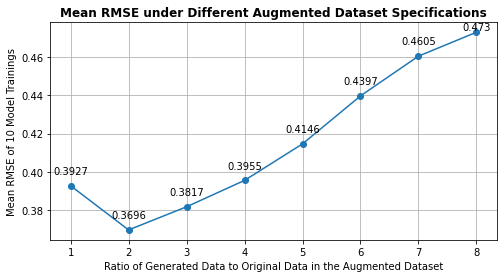

In [24]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,9),mean_value_list,marker='o', linestyle='-')
for i in range(len(mean_value_list)):
    if i == 7:
        plt.text(i+1, mean_value_list[i], f'{mean_value_list[i]}', ha='center', va='bottom')
    else:
        plt.text(i+1, mean_value_list[i]+0.005, f'{mean_value_list[i]}', ha='center', va='bottom')
## 10 Model Trainings under Different Augmented Dataset Specifications"
plt.title('Mean RMSE under Different Augmented Dataset Specifications',fontweight='bold')
plt.xticks(range(1,9))
#plt.yticks(range(500,1200,100))
plt.xlabel('Ratio of Generated Data to Original Data in the Augmented Dataset')
plt.ylabel('Mean RMSE of 10 Model Trainings')
plt.grid(True)
plt.show()

In [5]:
nn_mean_value_list = [0.06929,0.07090,0.07073,0.06834,0.07469,0.07068,0.07055, 0.07051]

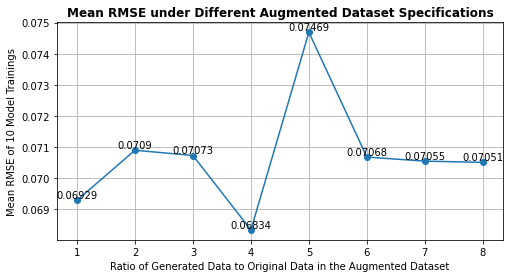

In [7]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,9),nn_mean_value_list,marker='o', linestyle='-')
for i in range(len(nn_mean_value_list)):
    if i == 7:
        plt.text(i+1, nn_mean_value_list[i], f'{nn_mean_value_list[i]}', ha='center', va='bottom')
    else:
        plt.text(i+1, nn_mean_value_list[i], f'{nn_mean_value_list[i]}', ha='center', va='bottom')
## 10 Model Trainings under Different Augmented Dataset Specifications"
plt.title('Mean RMSE under Different Augmented Dataset Specifications',fontweight='bold')
plt.xticks(range(1,9))
#plt.yticks(range(500,1200,100))
plt.xlabel('Ratio of Generated Data to Original Data in the Augmented Dataset')
plt.ylabel('Mean RMSE of 10 Model Trainings')
plt.grid(True)
plt.show()

In [13]:
rmse_list
##trtr:RMSE: 0.41115573320780013


[0.3944937687960956,
 0.39328179648552375,
 0.3918177473080944,
 0.3921377436927198,
 0.3929341963191927,
 0.39517349542945424,
 0.3910078590014119,
 0.39215352215382693,
 0.39226648415906956,
 0.39171121763422995]

In [18]:
sum([0.0775,
0.0653,
0.0683,
0.0669,
0.0757,
0.0672,
0.0803,
0.0721,
0.0618,
0.0642,
])/10
sum([0.0766,
0.0663,
0.0828,
0.0724,
0.0573,
0.0727,
0.0605,
0.0804,
0.0759,
0.0600
])/10

0.07049000000000001

In [2]:
rmse_list =[0.3944937687960956,
 0.39328179648552375,
 0.3918177473080944,
 0.3921377436927198,
 0.3929341963191927,
 0.39517349542945424,
 0.3910078590014119,
 0.39215352215382693,
 0.39226648415906956,
 0.39171121763422995]
mean_rmse = sum(rmse_list)/10
mean_rmse

0.3926977830979619